# FCC Filings on CBRS policy making analysis - Machine Learning VS Deep Learning

# Introduction

This project's aim, is to explore the world of *Natural Language Processing* (NLP) by building what is known as a **Sentiment Analysis Model**. A sentiment analysis model is a model that analyses a given piece of text and predicts whether this piece of text expresses positive or negative sentiment.

We are going to be using the stakeholder comments from the FCC website as our dataset which contains around 300 comments. Since the comments are not labeled, I have gone and did this myself by reading through every filing and using common sense to derive the sentiment of the comment.

After a series of **cleaning and data processing**, and after visualizing our data in a **word cloud**, we will be building a **Naive Bayezian** model. This model's goal would be to properly classify positive and negative comments in terms of sentiment.
Next, we will propose a much more advanced solution using a **deep learning** model: **LSTM**. This process will require a different kind of data cleaning and processing. Also, we will discover **Word Embeddings**, **Dropout** and other machine learning related concepts.

### **Table of Content:**

 1. [Importing and Discovering the Dataset](#head-1)  
 2. [Cleaning and Processing the Data](#head-2)  
  2.1. [Tokenization](#head-2-1)  
  2.2. [Lemmatization](#head-2-2)  
  2.3. [Cleaning the Data](#head-2-3)  
 3. [Visualizing the Data](#head-3)
 4. [Naive Bayesian Model](#head-4)  
  4.1. [Splitting the Data](#head-4-1)  
  4.2. [Training the Model](#head-4-2)  
  4.3. [Testing the Model](#head-4-3)  
  4.4. [Asserting the Model](#head-4-4)    
 5. [Deep Learning Model - LSTM](#head-5)  
  5.1. [Data Pre-processing](#head-5-1)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1.1. [Word Embeddings](#head-5-1-1)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1.2. [Global Vectors for Word Representation (GloVe)](#head-5-1-2)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1.3. [Data Padding](#head-5-1-3)  
  5.2. [Data Transformation](#head-5-2)  
  5.3. [Building the Model](#head-5-3)  
  5.4. [Training the Model](#head-5-4)  
  5.5. [Investigating Possibilties to Improve the Model](#head-5-5)  
&nbsp;&nbsp;&nbsp;&nbsp;5.5.1. [Regularization - Dropout](#head-5-5-1)  
  5.7. [Inspecting Wrongly Predicted Data](#head-5-6)
 7. [Pickling](#head-6)

# 1. Importing and Discovering the Dataset <a class="anchor" id="head-1"></a>

In [1]:
from time import time
import random
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reading the dataset
df_raw = pd.read_csv('processed_dataframe_with_sentiment.csv', encoding = "latin-1", delimiter=',')

# Show the first 5 rows of the dataframe.
df_raw.head()

Unnamed: 0  Unnamed: 0.1 Date Received Type of Filing Submission Type  \
0           0             1     8/29/2018        COMMENT        STANDARD   
1           1             2    12/29/2017        COMMENT        STANDARD   
2           2             3    12/29/2017        COMMENT        STANDARD   
3           3             4    12/28/2017        COMMENT        STANDARD   
4           4             5      8/9/2017        COMMENT        STANDARD   

      Proceeding ID                    Name of Filer(s) Total Page Count  \
0         ="12-354"         Midcontinent Communications               15   
1  ="17-258,12-354"                   Daniel R. Vincent               20   
2  ="12-354,17-258"                             Verizon               19   
3         ="12-354"                        Michael Polk                1   
4         ="12-354"  United States Cellular Corporation               19   

                                             Content  Sentiment  
0   Dear Ms. Dortch, Midcontinent Communications ...          2  
1    My name is Daniel R. Vincent. I am Professor...          1  
2    Verizon supports the Commissionâs proposed...          2  
3   To whom it may concern,  For several yrs I ha...          0  
4   Before the  FEDERAL COMMUNICATIONS COMMISSION...          2

In [3]:
# The label '2' denotes positive sentiment and '0' denotes negative sentiment
df_raw['Sentiment'].value_counts()

2    144
0    138
1     38
Name: Sentiment, dtype: int64

In [4]:
# Remove every column except for the content and the sentiment
df = df_raw[['Sentiment', 'Content']]
df.head()

Sentiment                                            Content
0          2   Dear Ms. Dortch, Midcontinent Communications ...
1          1    My name is Daniel R. Vincent. I am Professor...
2          2    Verizon supports the Commissionâs proposed...
3          0   To whom it may concern,  For several yrs I ha...
4          2   Before the  FEDERAL COMMUNICATIONS COMMISSION...

In [5]:
# Separating positive and negative comments
df['Sentiment'] = df['Sentiment'].replace(1,2)
df_pos = df[df['Sentiment'] == 2]
df_neg = df[df['Sentiment'] == 0]
print(len(df_pos), len(df_neg))

182 138


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [6]:
# Concatenate positive and negative groups and storing them back into a single dataframe
df = pd.concat([df_pos, df_neg])
len(df)

320

# 2. Cleaning and Processing the Data <a class="anchor" id="head-2"></a>

## 2.1. Tokenization <a class="anchor" id="head-2-1"></a>

Before classification, we first need to *tokenize* our data.
**Tokenization** is the process of splitting up a single string of text into a list of individual words, or *tokens*.
<br>

Python has a built in string method: *string.split()*, that splits up any given string into a list based on a splitting character (if not specified, will default to *white space*).
<br>

In this example, we will use the **word_tokenize** provided by the *nltk* library.

More info can be found at: https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual.

In [8]:
nltk.download('punkt')

start_time = time()

from nltk.tokenize import word_tokenize
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters and trims the rest
# For example, it will transform the word: 'Helloooooooooo' to: 'Hellooo'

data = []

X = df['Content'].tolist()
Y = df['Sentiment'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text and its corresponding label
for x, y in zip(X, Y):
    if y == 2:
        data.append((word_tokenize(x), 1))
    else:
        data.append((word_tokenize(x), 0))

# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


CPU Time: 4.873124837875366


## 2.2. Lemmatization <a class="anchor" id="head-2-2"></a>

According to the Cambridge English Dictionary, **Lemmatization** is the process of reducing the different forms of a word to one single form, for example, reducing "builds", "building", or "built" to the lemma "build". This will help our classifier by treating all variants of a given word as being references to the original lemma word. For example, it will avoid interpreting "living" and "live" as completely different inputs.
<br>

In this example, we will use *nltk*'s **WordNetLemmatizer** to accomplish this task. This lemmatizer however takes as input two arguments: a list of tokens to be lemmatized as well as their corresponding *part of speech*. The most common parts of speech in english are nouns and verbs. In order to extract each token's part of speech, we will utilize *nltk*'s *post_tag* function, that takes an input a list of tokens, and returns a list of tuples, where each tuple is composed of a token and its corresponding position tag. Various position tags can be outputted from the pos_tag function, however the most notable ones are:
* **NNP**: Noun, proper, singular
* **NN**: Noun, common, singular or mass.
* **VBG**: Verb, gerund or present participle.
* **VBN**: Verb, past participle.

A full list of position tags can be found at: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [9]:
nltk.download('averaged_perceptron_tagger')

from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

# Print the pos_tag() output
print(pos_tag(data[0][0]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('Dear', 'NNP'), ('Ms.', 'NNP'), ('Dortch', 'NNP'), (',', ','), ('Midcontinent', 'NNP'), ('Communications', 'NNP'), ('(', '('), ('Midco', 'NNP'), (')', ')'), ('supports', 'VBZ'), ('the', 'DT'), ('Conimission', 'NNP'), ("'s", 'POS'), ('efforts', 'NNS'), ('to', 'TO'), ('promote', 'VB'), ('investment', 'NN'), ('in', 'IN'), ('the', 'DT'), ('3.5', 'CD'), ('GHz', 'NNP'), (',', ','), ('Citizens', 'NNP'), ('Broadband', 'NNP'), ('Radio', 'NNP'), ('Service', 'NNP'), ('(', '('), ('CBRS', 'NNP'), (')', ')'), ('band', 'NN'), (',', ','), ('and', 'CC'), ('has', 'VBZ'), ('made', 'VBN'), ('suggestions', 'NNS'), ('herein', 'VBP'), ('to', 'TO'), ('ensure', 'VB'), ('that', 'IN'), ('the', 'DT'), ('valuable', 'JJ'), ('CBRS', 'NNP'), ('band', 'NN'), ('can', 'MD'), ('be', 'VB'), ('used', 'VBN'), ('to', 'TO'), ('further', 'RBR'), ('broadband', 'VB'), ('access', 'NN'), ('for', 'IN'), ('rural', 'JJ'), ('America', 'NNP'), ('.', '.'), ('Specifically', 'RB'), (',', ','), ('the', 'DT'), ('Commission', 'NNP'), ('sho

In [11]:
nltk.download('wordnet')

def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Print the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['Dear', 'Ms.', 'Dortch', ',', 'Midcontinent', 'Communications', '(', 'Midco', ')', 'support', 'the', 'Conimission', "'s", 'effort', 'to', 'promote', 'investment', 'in', 'the', '3.5', 'GHz', ',', 'Citizens', 'Broadband', 'Radio', 'Service', '(', 'CBRS', ')', 'band', ',', 'and', 'have', 'make', 'suggestion', 'herein', 'to', 'ensure', 'that', 'the', 'valuable', 'CBRS', 'band', 'can', 'be', 'use', 'to', 'further', 'broadband', 'access', 'for', 'rural', 'America', '.', 'Specifically', ',', 'the', 'Commission', 'should', 'issue', 'county-sized', 'or', 'small', 'priority', 'access', 'license', '(', 'PALs', ')', ';', 'consider', 'similar', 'rule', 'for', 'the', 'CBRS', 'PALs', 'and', 'the', '2.5', 'Educational', 'Broadband', 'Services', '(', 'EBS', ')', 'white', 'space', ';', 'institute', 'performance', 'requirement', 'if', 'longer-termed', 'PALs', 'be', 'authorize', ';', 'and', 'require', 'all', 'provider', 'to', 'use', 'the', 'Spectrum', 'Access', 'Systems', '(', 'SASs', ')', '.', 'Backgrou

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2.3. Cleaning the Data <a class="anchor" id="head-2-3"></a>


In [12]:
nltk.download('stopwords')

import re, string
from nltk.corpus import stopwords

# Stopwords are frequently used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text and tag the tokens.
def remove_noise(tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = token.lower()

        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)

    return cleaned_tokens

# Print the remove_noise() output
print(remove_noise(data[0][0]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['dear', 'ms.', 'dortch', 'midcontinent', 'communications', 'midco', 'support', 'conimission', 'effort', 'promote', 'investment', '3.5', 'ghz', 'citizens', 'broadband', 'radio', 'service', 'cbrs', 'band', 'make', 'suggestion', 'herein', 'ensure', 'valuable', 'cbrs', 'band', 'use', 'broadband', 'access', 'rural', 'america', 'specifically', 'commission', 'issue', 'county-sized', 'small', 'priority', 'access', 'license', 'pals', 'consider', 'similar', 'rule', 'cbrs', 'pals', '2.5', 'educational', 'broadband', 'services', 'ebs', 'white', 'space', 'institute', 'performance', 'requirement', 'longer-termed', 'pals', 'authorize', 'require', 'provider', 'use', 'spectrum', 'access', 'systems', 'sass', 'background', 'midco', 'midco', 'provide', 'wired', 'internet', 'upper', 'midwest', 'since', '1996', 'currently', 'serve', '385,000', 'internet', 'customer', 'south', 'dakota', 'north', 'dakota', 'minnesota', 'wisconsin', 'lawrence', 'area', 'kansas', 'good', 'serve', 'rural', 'customer', 'topograp

In [13]:
start_time = time()

# As the Naive Bayesian classifier accepts inputs in a dictionary-like structure,
# we have to define a function that transforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

final_data = []

# Transforming the data to fit the input structure of the Naive Bayesian classifier
for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))

print('Data Prepared for model, CPU Time:', time() - start_time)

# Print our final (tokenized, cleaned and lemmatized) data list
final_data[:1]

Removed Noise, CPU Time: 35.167505741119385
Data Prepared for model, CPU Time: 0.07617974281311035


[({'dear': True,
   'ms.': True,
   'dortch': True,
   'midcontinent': True,
   'communications': True,
   'midco': True,
   'support': True,
   'conimission': True,
   'effort': True,
   'promote': True,
   'investment': True,
   '3.5': True,
   'ghz': True,
   'citizens': True,
   'broadband': True,
   'radio': True,
   'service': True,
   'cbrs': True,
   'band': True,
   'make': True,
   'suggestion': True,
   'herein': True,
   'ensure': True,
   'valuable': True,
   'use': True,
   'access': True,
   'rural': True,
   'america': True,
   'specifically': True,
   'commission': True,
   'issue': True,
   'county-sized': True,
   'small': True,
   'priority': True,
   'license': True,
   'pals': True,
   'consider': True,
   'similar': True,
   'rule': True,
   '2.5': True,
   'educational': True,
   'services': True,
   'ebs': True,
   'white': True,
   'space': True,
   'institute': True,
   'performance': True,
   'requirement': True,
   'longer-termed': True,
   'authorize': Tru

# 3. Visualizing the Data <a class="anchor" id="head-3"></a>

**Word Clouds** are one of the best visualizations for words frequencies in text documents.<br>Essentially, what it does is that it produces an image with frequently-appearing words in the text document, where the most frequent words are shown with bigger font sizes, and less frequent words with smaller font sizes.

     |████████████████████████████████| 366 kB 20.7 MB/s eta 0:00:01
Positive words


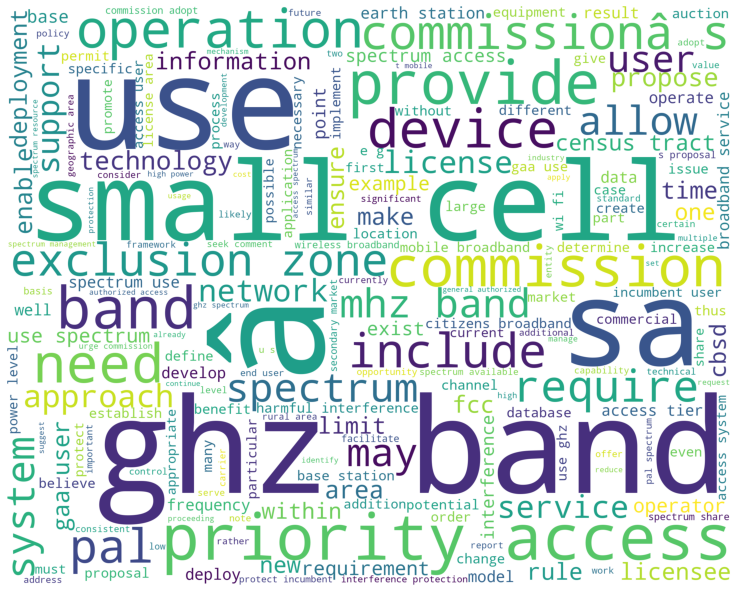

Negative words


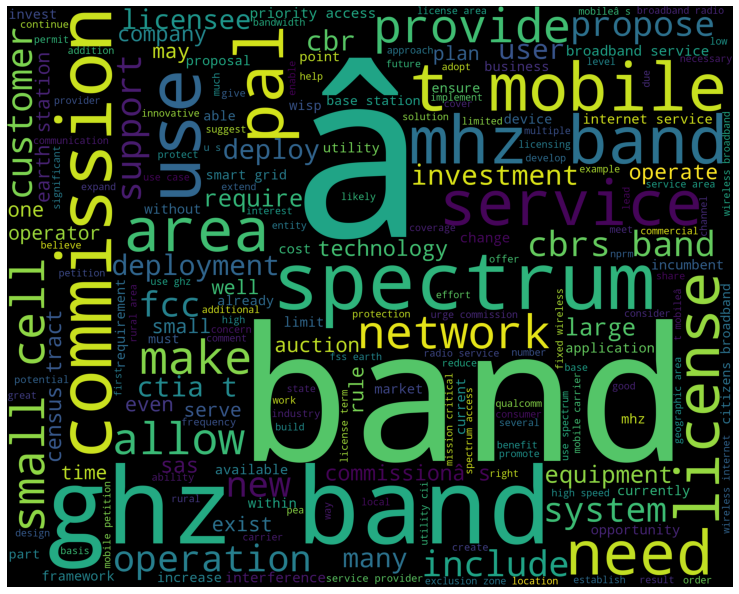

CPU Time: 25.00286102294922


In [14]:
!pip install wordcloud

from wordcloud import WordCloud, STOPWORDS

start_time = time()

positive_words = []
negative_words = []

# Separating out positive and negative words in order to visualize each set of words independently
for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 1:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])

# Defining our word cloud drawing function
def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 2500,
                          height = 2000
                         ).generate(' '.join(data))
    plt.figure(1, figsize = (13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(positive_words, 'white')
print("Negative words")
wordcloud_draw(negative_words)

print('CPU Time:', time() - start_time)

It's quite interesting to observe the (higher) occurence of *\"t-mobile\"* in the negative comments.

# 4. Naive Bayesian Model <a class="anchor" id="head-4"></a>

Now that our data is *somewhat* clean, we can use it to build our classification model. One of the most commonly used classification models in Natural Language Processing (NLP) is the Naive Bayesian.<br>
**Naive Bayesian** classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but rather a family of algorithms where all of them make the following *naive* assumptions:
* All features are independent from each other.
* Every feature contributes equally to the output.

In our case, these two assumptions can be interpreted as:
* Each word is independent from the other words, no relation between any two words of a given sentence.
* Each word contributes equally, throughout all sentences, to the decision of our model, regardless of its relative position in the sentence.

<u>Example:</u> "This is bad" / "This is very bad" or "Such a kind person" / "This kind of chocolate is disgusting", in both cases the Naive Bayesian classifier would give the same importance for the words 'bad' and 'kind', despite them having a stronger meaning and a different meaning respectively in first and second sentences.

Nevertheless, Naive Bayesian are widely used in NLP and they often output great results.<br>

The **Bayes' Theorem** describes the probability of an event $A$, based on prior knowledge of conditions $B$ that might be related to the event:
$P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}$.<br>
In our case, this can be intuitively interpreted as the probability of a comment being positive, based on prior knowledge of the words inside the input text.
In a nutshell, this probability is: the probability of the first word occurring in a positive comment, times, the probability of the second word occurring in a positive comment, ..., times, the probability of a comment being positive.

Read more at: https://www.geeksforgeeks.org/naive-bayes-classifiers/

## 4.1. Splitting the Data <a class="anchor" id="head-4-1"></a>

First, we need to split our data into two sets: Training and Testing sets.<br>
* **Train Data** is data used in order to build and train our classification model.
* **Test Data** is data, that our classifier model has never seen before, used in order to assert the accuracy and test our classification model.

In [34]:
random.Random(140).shuffle(final_data)

# Here we decided to split our data as 80% train data and 20% test data
trim_index = int(len(final_data) * 0.80)

train_data = final_data[:trim_index]
test_data = final_data[trim_index:]

## 4.2. Training the Model <a class="anchor" id="head-4-2"></a>

Now it's time to train our model on our training data.
<br>
In this notebook, we will utilize *nltk*'s **NaiveBayesClassifier**.

In [35]:
start_time = time()

from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

# Output the model accuracy on the train and test data
print('Accuracy on train data:', classify.accuracy(classifier, train_data))
print('Accuracy on test data:', classify.accuracy(classifier, test_data))

# Output the words that provide the most information about the sentiment of a filing.
# These are words that are heavily present in one sentiment group and very rarely present in the other group.
print(classifier.show_most_informative_features(20))

print('\nCPU Time:', time() - start_time)

Accuracy on train data: 0.73828125
Accuracy on test data: 0.75
Most Informative Features
               evolution = True                1 : 0      =     17.4 : 1.0
                    ntia = True                1 : 0      =     17.4 : 1.0
              co-channel = True                1 : 0      =     15.8 : 1.0
                  adjust = True                1 : 0      =     14.7 : 1.0
              opposition = True                0 : 1      =     13.3 : 1.0
                accurate = True                1 : 0      =     13.0 : 1.0
               knowledge = True                1 : 0      =     12.4 : 1.0
                 collect = True                1 : 0      =     12.4 : 1.0
                    tvws = True                1 : 0      =     12.4 : 1.0
             responsible = True                1 : 0      =     11.9 : 1.0
               cognitive = True                1 : 0      =     11.9 : 1.0
                  source = True                1 : 0      =     11.9 : 1.0
           

A good 75% accuracy on the test set and 73% on the training set with a very naive algorithm!

Taking a look at the 20 most informative features of the model.

## 4.3. Testing the Model <a class="anchor" id="head-4-3"></a>

This model has various shortcomings.

As the model only evaluates sentences at an independent word level, it performs very poorly when it comes to negations and other multi-words constructs. For example, is the model gets the following input: **The proposal was good!**, it would simply take each individual word (here, and after cleaning the input, *\"proposal\"* and *\"good\"*) and calculate each word's probability to be either positive and negative and finally multiply everything together. Thus, we would expect the model to perform poorly on examples such: **The proposal was not good!** or **I'm not very happy**.

In [36]:
custom_sentence = "Good"

custom_tokens = remove_noise(word_tokenize(custom_sentence))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


In [37]:
custom_sentence = "Not good"

custom_tokens = remove_noise(word_tokenize(custom_sentence))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


Also, the model isn't robust against sarcastic sentences.

Finally, it is worth mentioning one more weakness of such a model: it does not generalize well.

The model would perform greatly on data similar to the data it trained on. For example, if the model learned that **I love cakes** and **I love food** carry a positive sentiment, it would be pretty easy for it to classify **I love FCC** as a sentence carrying a positive sentiment. However, if the model were to classify **I fancy FCC**, it would most probably miss-classify it. As it never encountered any of these words before, therefore it is unable to properly classify it, and would simply output a random choice.

## 4.4. Asserting the Model <a class="anchor" id="head-4-4"></a>

Finally, let's further assert our model by plotting the AUC and the confusion matrix of the model.

In [41]:
from sklearn import metrics

# Storing all values in a list
y = [test_data[i][1] for i in range(len(test_data))]
# Storing all probabilities of having a positive sentiment in a list
probs = [classifier.prob_classify(test_data[i][0]).prob(1) for i in range(len(test_data))]

# Making sure both values a re equal
print(len(y), len(probs))

# performing the roc curve calculations
fpr, tpr, thresholds = metrics.roc_curve(y, probs)

# Printing the Area Under Curve (AUC) of the ROC curve (the closer to 1, the better)
auc = metrics.roc_auc_score(y, probs)
print('AUC: %.3f' % auc)

64 64
AUC: 0.750


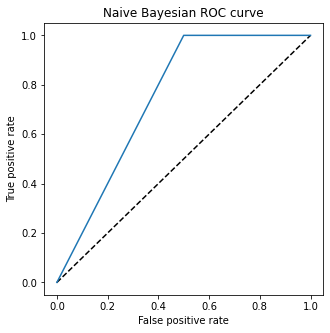

In [42]:
# Plotting the ROC Curve
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Naive Bayesian ROC curve')
plt.show()

In [43]:
# Creating a confusion matrix

probs = [classifier.classify(test_data[i][0]) for i in range(len(test_data))]
y = np.asarray(y)
probs = np.asarray(probs)
pd.crosstab(y, probs, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted  0   1  All
Actual               
0          6  16   22
1          0  42   42
All        6  58   64

# 5. Deep Learning Model - LSTM <a class="anchor" id="head-5"></a>

**Deep Learning** is a very rapidly growing field, that is proving to be extremely beneficial in various scenarios. One of those scenarios is the ability to process text data in a much more complex and powerful manner. In the next section of the notebook we will be focusing on implementing a Deep Learning model that will successfully tackle and solve the above mentioned shortcomings of the Naive Bayes model.

A **L**ong **S**hort-**T**erm **M**emory, or **LSTM**, is a type of machine learning neural networks. More specifically, it belongs to the family of **R**ecurrent **N**eural **N**etwords (**RNN**) in Deep Learning, which are specifically conceived in order to process *temporal data*. Temporal data is defined as data that is highly influenced by the order that it is presented in. This means that data coming before or after a given data can greatly affect this data. Text data is an example of temporal data. For example, let's consider the following sentence:

>*Amina is not very happy. She's still mad at you!*

In the above sentence, the word *not* greatly influences the meaning of the upcoming words *very happy*. Also, we used the word *she* as we are speaking about a female subject.

Also, here's an example conveying the influence of words' positions directly influencing a sentence's meaning:

>*Are you as clever as I am?*
>
>*Am I as clever as you are?*

------------

LSTM is an advanced and complex deep learning architecture and we will try to tap into it.

## 5.1. Data Pre-processing <a class="anchor" id="head-5-1"></a>

In order to feed our text data to our LSTM model, we'll have to go through several extra preprocessing steps.

Most neural networks expect *numbers* as inputs. Thus, we'll have to convert our *text* data to *numerical* data.

One way of doing so would be the following: collect all possible words in our dataset and generate a *dictionary* containing all unique words in our text corpus, then sort all of these words alphabetically and assign to each word an *index*. So for example, let's say our dictionary's length turned out to be 100,000 words. The word "a" would be assigned the index 0, the word "aab" would be assigned the index 1, and so on, until we reach the last word in our dictionary, say "zyx", and assign to it the index 99,999. Now each word is represented with a numerical value, and we can feed the numerical value of each word to our model.

This step alone is not enough to be able to train good Deep Learning models. If you think about it, when the model reads an input 20,560 and then another input 20,561 for example, it would assume that these values are "close". However, those inputs could be the indexes of totally unrelated words, such as "cocktail" and "code", appearing right next to each  other in the sorted dictionary.

### 5.1.1. Word Embeddings <a class="anchor" id="head-5-1-1"></a>

Word embeddings are basically a way for us to convert words to *representational vectors*. What I mean by this is that, instead of mapping each word to an index, we want to map each word to a vector of real numbers, representing this word.

The goal here is to be able to generate similar representational vectors for words that have similar meaning. For example, when feeding the words "excited" and "thrilled" to the word embedding model, we would like the model to output "close" representations for both words. Whereas if we feed the words "excited" and "homework", we would like the model to output "far" representations for both words.


[Interesting paper](https://papers.nips.cc/paper/2016/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf)

### 5.1.2. Global Vectors for Word Representation (GloVe) <a class="anchor" id="head-5-1-2"></a>

Building and training good word embeddings is a huge process requiring millions of data samples and great computational power. Luckily for us, University of Stanford already did this for us and published their results for free on their official [website](https://nlp.stanford.edu/projects/glove/). Their model is called **GloVe**, and it's going to be what we'll use in the next steps

In [25]:
# Downloading and unzipping the glove word embeddings from the official website

#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [44]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

GloVe embeddings differ depending on the type of data they were trained on, the length of the vocabulary, the size of the representational vectors and so on.

We've previously downloaded GloVe vectors trained on 6 Billion tokens and having a vocabulary size of 400,001 unique words. This is the smallest model from GloVe. Next we will load the vectors that are 300-dimensional.

In [45]:
# Loading the 50-dimensional GloVe embeddings
# This method will return three dictionaries:
# * word_to_index: a dictionary mapping from words to their indices in the vocabulary
# * index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary
# * word_to_vec_map: dictionary mapping words to their GloVe vector representation
# Note that there are 400,001 words, with the valid indices ranging from 0 to 400,000

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.300d.txt')

In [46]:
word_to_index['sweet']

349415

In [47]:
word_to_vec_map['sweet']

array([-6.8296e-01, -6.4358e-02,  6.2038e-01, -1.1316e-01, -5.3879e-01,
       -9.6135e-02,  4.8471e-01, -9.6305e-03, -2.2841e-02, -1.6405e-01,
        6.6563e-02, -8.4361e-02, -2.7328e-01,  4.6922e-01, -2.2793e-02,
        3.5652e-01, -6.4287e-01, -2.2241e-01, -5.2688e-02,  2.2469e-01,
       -7.4828e-03,  1.0740e+00, -3.3634e-01,  2.0812e-01, -6.8433e-01,
        1.8339e-01,  8.4325e-02, -3.0902e-01, -2.8869e-01, -1.1664e-01,
       -6.5637e-01,  9.5440e-02, -8.9085e-01, -1.8068e-01, -1.0176e+00,
        1.0114e+00,  1.7639e-01, -1.7907e-01, -1.6965e-01, -8.8342e-02,
       -8.6875e-02,  7.0086e-02,  5.2425e-01,  2.7776e-01,  1.0038e-01,
        1.6397e-01,  5.6711e-01,  1.2807e-01, -2.6701e-02,  1.1704e-01,
        2.7419e-01,  6.6856e-01,  2.5083e-01, -1.3858e-01, -4.6366e-01,
       -7.4238e-01,  1.2600e-02,  1.7065e-01,  8.8043e-01, -7.8256e-01,
        2.9616e-01, -2.0707e-01,  5.9304e-01, -5.6095e-02, -5.4717e-01,
       -7.9165e-01,  1.7276e-02,  1.1641e-01, -9.0742e-03, -1.71

As this word embedding only considers 400,000 unique words, it might encounter words it has never seen before. For example, the word "LSTM" is most likely not included in those 400,000 words.

In order to overcome such scenarios, word embeddings reserve an extra spot for "unknown" words, also denoted with the keyword **unk**.

In [48]:
word_to_index['unk']

372306

Below is a short example of the usage of the cosine similarity in order to find correlations in the data.

We can observe that the words *dog* and *cat* are highly positively similar. Whereas the words *dog* and *screwdriver* are not related at all, having a close to 0 similarity measure.

> Note that the cosine similarity return values between -1 and +1, where **-1** denote completely opposite meanings, **+1** denote completely identical meanings and **0** denote totally unrelated meanings.

In [49]:
def cosine_similarity(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u * norm_v)
    return cosine_similarity

In [50]:
cosine_similarity(word_to_vec_map['dog'], word_to_vec_map['cat'])

0.6816746611786187

In [51]:
cosine_similarity(word_to_vec_map['dog'], word_to_vec_map['screwdriver'])

0.07137720194022988

### 5.1.3. Data Padding  <a class="anchor" id="head-5-1-3"></a>

Further in our training we would like to speed the process up by splitting data into *mini-batches*. Batch learning is basically the process of training on several examples at the same time, which greatly decreases the training time!

However in order to be able to utilize batch learning, keras requires all data within the same batch to have the same length or *dimension*. Whereas in our text data, each example could have a variable sentence length. In order to overcome this issue, we will go over all of our data, and calculate the length of the longest phrase (in terms of words). Then, we will 0-pad all of the data sequences so that they will all have the same *max_len* calculated.

Let's consider a *max_len* of 5 words, and the two sentences *I love sharks* and *I will be ready*.
First, we will convert these sentences to their corresponding index representation, then 0-pad them for the *max_len* 5. After we've done that, we can now feed the resulting lists into a word embedding layer in order to get the representational vectors for each index (representing a given word).

In the next cell we will write some code in order to perform the above-described process, with the exception of passing the lists to the embedding layer, as this step will be handled by the model.

Note that the first step in this process is similar to the process previously performed for the Naive Bayes model.

## 5.2. Data Transformation <a class="anchor" id="head-5-2"></a>

In [52]:
start_time = time()

unks = []
UNKS = []

# This function will act as a "last resort" in order to try and find the word
# in the words embedding layer. It will basically eliminate occurring
# instances of a similar character
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res


def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index


# Here we will utilize the already computed 'cleaned_tokens_list' variable

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label

print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

Removed Noise, CPU Time: 0.00029277801513671875
max_len: 8121
Data Prepared for model, CPU Time: 0.20006728172302246
[[118309. 251414. 128092. ...      0.      0.      0.]
 [256046. 116708. 379261. ...      0.      0.      0.]
 [377662. 348215. 372306. ...      0.      0.      0.]
 [146233. 106045. 105934. ...      0.      0.      0.]
 [ 53465. 372306. 313201. ...      0.      0.      0.]]
[1. 1. 1. 1. 1.]


## 5.3. Building the Model <a class="anchor" id="head-5-3"></a>

In [53]:
!pip install keras
!pip install tensorflow

import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 394.3 MB 20 kB/s s eta 0:00:01     |███████████▏                    | 136.9 MB 57.8 MB/s eta 0:00:05
     |████████████████████████████████| 42 kB 2.3 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 7.4 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 58.3 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 69.2 MB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 56.7 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 57.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 57.2 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 55.2 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 142 kB 63.9 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 63.2 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 69.4 MB/s eta 0:00:01
  Created wheel for termcolor: fi

In [54]:
# Defining a function that will initialize and populate our embedding layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50

    emb_matrix = np.zeros((vocab_len, emb_dim))

    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [55]:
# Defining a sequencial model composed of firstly the embedding layer, than a pair of Bidirectional LSTMs,
# that finally feed into a sigmoid layer that generates our desired output between 0 and 1.

model = Sequential()

model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8121, 300)         120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 8121, 256)         439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 120,834,093
Trainable params: 833,793
Non-trainable params: 120,000,300
_________________________________________________________________


In [60]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accuracy as the metric to track and ameliorate

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [62]:
len(X_train)

256

In [63]:
len(X_test)

64

## 5.4. Training the Model <a class="anchor" id="head-5-4"></a>

In [64]:
# Setting a batch size of 20 and training our model for 20 epochs

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size = 20, shuffle=True, verbose=1)

Epoch 1/10
13/13 [==============================] - 369s 28s/step - loss: 0.6356 - accuracy: 0.5705 - val_loss: 0.4230 - val_accuracy: 0.8594
Epoch 2/10
13/13 [==============================] - 364s 28s/step - loss: 0.4135 - accuracy: 0.8364 - val_loss: 0.3403 - val_accuracy: 0.8281
Epoch 3/10
13/13 [==============================] - 363s 28s/step - loss: 0.3065 - accuracy: 0.8765 - val_loss: 0.3656 - val_accuracy: 0.8438
Epoch 4/10
13/13 [==============================] - 367s 28s/step - loss: 0.3802 - accuracy: 0.8320 - val_loss: 0.3402 - val_accuracy: 0.8750
Epoch 5/10
13/13 [==============================] - 368s 28s/step - loss: 0.1529 - accuracy: 0.9336 - val_loss: 0.4356 - val_accuracy: 0.8125
Epoch 6/10
13/13 [==============================] - 369s 28s/step - loss: 0.1215 - accuracy: 0.9523 - val_loss: 0.5417 - val_accuracy: 0.8438
Epoch 7/10
13/13 [==============================] - 369s 28s/step - loss: 0.2311 - accuracy: 0.9049 - val_loss: 0.5337 - val_accuracy: 0.8594
Epoch 

In [65]:
# Defnining a handy function in order to plot various models accuracy and loss progress

def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

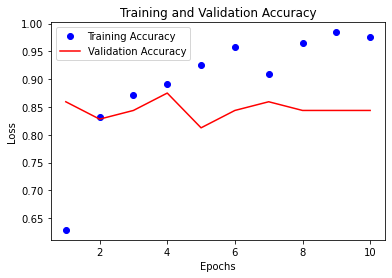

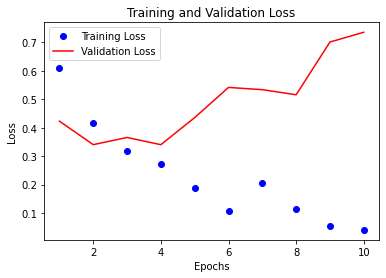

In [66]:
# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)

The training accuracy is amazing, exceeding **95%**. However, the validation accuracy increased slightly in the early epochs, reaching around **86%** on the 4th epoch, after which it keeps steady. Usually this is due to over-fitting.

**Over-Fitting** happens when the model's performance on validation data starts degrading or doesnt improve, while still achieving great progress on the test set. In other words, the model is doing exceptionally well on learning specific examples it has been trained on, but is failing to generalize.

## 5.5. Investigating Possibilties to Improve the Model <a class="anchor" id="head-5-5"></a>

We will try to introduce regularization to avoid over-fitting and improve the model. Trying dropout model technique.

### 5.5.1. Regularization - Dropout <a class="anchor" id="head-5-5-1"></a>

**Regularization** prevents a model from over-fitting the training data. It renders our model less sensible to every detail in the training data. This should allow the model to better generalize and have a better performance on the validation data, or any data it wasn't trained on.

**Dropout** is a simple and one of the most common regularization techniques. Dropout randomly eliminates several neuron connections in the network, making the model less complex, and forcing the model to only look at part of a given example. The random elimination of connections in the model is repeated randomly for each example training data.

For example, a dropout layer with a rate of 0.5 (50% of connections will be eliminated):

> "This news article looks interesting and could go viral soon."
>
> "I am doing my master thesis. This is my first time doing deep learning."

The output of the dropout layer could look like the following:

> "news article interesting viral soon"
>
> "Doing master thesis. First time deep learning"

As we can see the model will only have information on a part of the input example, and should be able to escape over-fitting particular characteristics of the training data.

### Model Building - Dropout

In [67]:
keras.backend.clear_session()

model_dropout = Sequential()

model_dropout.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_dropout.add(Dense(units=1, activation='sigmoid'))

model_dropout.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8121, 300)         120000300 
_________________________________________________________________
dropout (Dropout)            (None, 8121, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 8121, 256)         439296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 8121, 256)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 120,834,093
Trainable params: 833,793
Non-trainable params: 120,000,300
____________________________________

In [68]:
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Training - Dropout

In [69]:
model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size = 20, shuffle=True, verbose=1)

Epoch 1/10
13/13 [==============================] - 376s 29s/step - loss: 0.6588 - accuracy: 0.6184 - val_loss: 0.4016 - val_accuracy: 0.8281
Epoch 2/10
13/13 [==============================] - 369s 28s/step - loss: 0.4209 - accuracy: 0.8667 - val_loss: 0.3011 - val_accuracy: 0.8906
Epoch 3/10
13/13 [==============================] - 370s 29s/step - loss: 0.4577 - accuracy: 0.8067 - val_loss: 0.3862 - val_accuracy: 0.8594
Epoch 4/10
13/13 [==============================] - 370s 29s/step - loss: 0.3845 - accuracy: 0.8589 - val_loss: 0.3317 - val_accuracy: 0.8750
Epoch 5/10
13/13 [==============================] - 370s 29s/step - loss: 0.3509 - accuracy: 0.8582 - val_loss: 0.3276 - val_accuracy: 0.8750
Epoch 6/10
13/13 [==============================] - 373s 29s/step - loss: 0.3267 - accuracy: 0.8628 - val_loss: 0.3577 - val_accuracy: 0.8906
Epoch 7/10
13/13 [==============================] - 372s 29s/step - loss: 0.1856 - accuracy: 0.9454 - val_loss: 0.3359 - val_accuracy: 0.9062
Epoch 

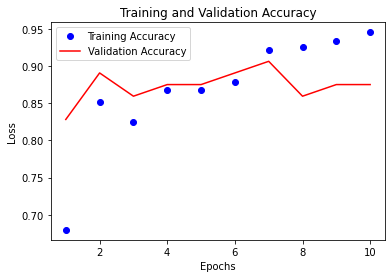

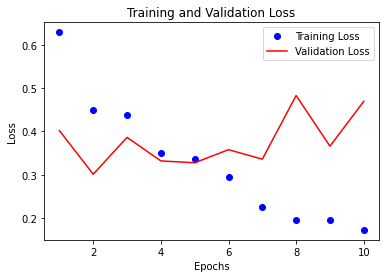

In [70]:
plot_acc_loss(model_dropout.history)

We can clearly see the effects of adding dropout layers on the training progress. The training accuracy is progressing at a much slower pace than it previously did. Nevertheless, the validation accuracy increases reaching **90%** but still variable since our data is random.

We can conclude that the regularization process did help us in our case even a tiny bit. Few percentages increased after adding dropout to our model.

Now let's see how we can improve our model using **data**.

## 5.7. Inspecting Wrongly Predicted Data <a class="anchor" id="head-5-6"></a>

Let's take a look at some of the wrongly classified data from the model.

In [71]:
def i_to_sentence(I):
    sentence = ""
    for i in I:
        if i:
            sentence += index_to_word[int(i)] + " "
        else:
            break
    return sentence

In [72]:
C = 0

pred = model.predict(X_test)

for i in range(len(X_test)):
    final_pred = 1 if pred[i] > 0.5 else 0

    if(final_pred != Y_test[i]):
        print('Expected sentiment: ' + str(int(Y_test[i])) + '. Input: ' + i_to_sentence(X_test[i]))
        C += 1

    if C > 100:
        break

Expected sentiment: 1. Input: amendment unk rules regard commercial operations unk 3650 mhz band docket unk dear ms. dortch group entrepreneur innovator develop new technology create job drive digital economy respective business depend expansion broadband eager support initiative get people connect april 2015 federal communications commission unanimously vote create citizens broadband radio service unk 3.5 ghz band measure create unk band suitable wireless broadband include 100 megahertz previously unavailable commercial use earmark military radar write today support fcc rule originally adopt 2015 affirm 2016 reject drastic change could undermine exist investment market expectation ability investor like rely fcc rule 2015 3.5 ghz band almost entirely unused across united states innovative spectrum share framework put place fcc include three tier one military incumbent priority access tier unk license general authorized access tier similar unlicensed spectrum use wi-fi three-tiered fram

Looking at this we can see why the model wouldn't properly classify several examples. Some other examples are hard to classify because of randomness of data, some have many uknown words and some may be wrongly labeled.

I would say that this model is relatively good in classifying the sentiment for a filing.


# 7. Pickling <a class="anchor" id="head-6"></a>

*“Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream is converted back into an object hierarchy.*<br>
This means that we can save on our drive any object in python. So, if were to come back to our code and decide to add a visualization or extra code, and instead of re-processing, we can *pickle* it on our drive and later load it back from our drive very fast.

In [73]:
import pickle

In [74]:
# Saving a python object to disk
pickle.dump(classifier, open("classifier.p", "wb"))

In [75]:
# Loading a python object from disk
classifier = pickle.load(open("classifier.p", "rb"))